# CNN Classification of Mel Spectrograms

Tried and follow
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [1]:
# For Colab only
from google.colab import drive
drive.mount('content/')
# /content/drive/MyDrive/bird-songs

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


## Training a model

In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import os.path

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, functional
from torch.optim import Adam

In [3]:
# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs'
if os.path.isdir(path) == True:
    run_on_colab = True
else:
    run_on_colab = False


if run_on_colab ==True:
    features = pd.read_csv('/content/content/MyDrive/bird-songs/features.csv', header=None, encoding='latin')
else:
    features = pd.read_csv('features.csv', header=None, encoding='latin')
features.columns= ['id', 'gen', 'sp', 'ssp', 'en', 'cnt', 'loc','type', 'q', 'length', 'bird-seen']
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen
0,418340,Branta,canadensis,NaN,Canada Goose,United States,"Au Sable SF - Big Creek Rd, Michigan",song,A,0:14,yes
1,417786,Branta,canadensis,NaN,Canada Goose,United States,"Drayton Plains Nature Center, Oakland County, ...","Hissing, peeping",A,1:04,unknown
2,409020,Branta,canadensis,NaN,Canada Goose,United States,"Watkins Lake State Park, Jackson County, Michigan","call, flight call",A,0:49,yes
3,388771,Branta,canadensis,NaN,Canada Goose,United States,"Cranberry Lake Park, Oakland County, Michigan",call,B,0:15,no
4,11837,Branta,canadensis,maxima,Canada Goose,United States,"Michigan, Pte. Mouillee SGA",call,B,0:19,unknown


In [4]:
# These are the top species we selected for our analysis
selected_species = ["Kirtland's Warbler",
                    'Common Yellowthroat',
                    'Red-winged Blackbird',
                    'Grey Catbird',
                    'American Redstart']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Kirtland's Warbler": 0, 'Common Yellowthroat': 1, 'Red-winged Blackbird': 2, 'Grey Catbird': 3,
          'American Redstart': 4}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

# Taking 20% of the dataset off for testing
train, test = train_test_split(dataset, test_size=0.2)

print(train.label.value_counts())
print('')
print(test.label.value_counts())

4    32
2    32
3    28
1    27
0    21
Name: label, dtype: int64

2    10
1     9
0     7
4     5
3     5
Name: label, dtype: int64


In [5]:
# loading training images
train_img = []
for img_name in tqdm(train['id']):
    # defining the image path
    if run_on_colab == True:
        image_path = '/content/content/MyDrive/bird-songs/images/mel_spectrograms_8sec/' + str(img_name) + '.jpg' 
    else:
        image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['label'].values
train_x.shape

100%|██████████| 140/140 [00:02<00:00, 68.88it/s]


(140, 432, 1008)

In [6]:
# loading training images
test_img = []
for img_name in tqdm(test['id']):
    # defining the image path
    if run_on_colab == True:
        image_path = '/content/content/MyDrive/bird-songs/images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
    else:
        image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
# defining the target
test_y = test['label'].values
test_x.shape

100%|██████████| 36/36 [00:00<00:00, 73.22it/s]


(36, 432, 1008)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdc3a9b5850>,
 <matplotlib.image.AxesImage at 0x7fdc3a979610>)

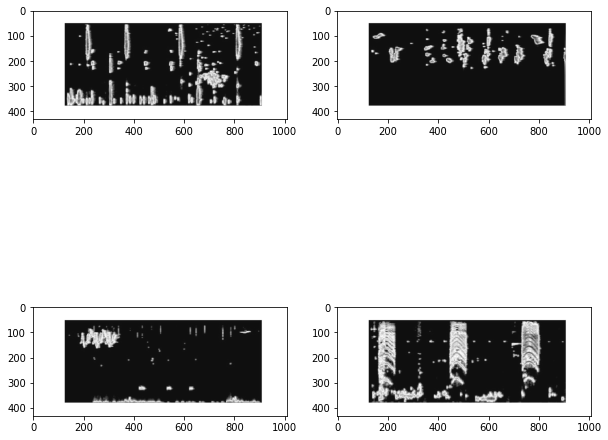

In [7]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

## CNN

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
train_x[0].reshape(-1, 1).shape
np.expand_dims(train_x[0], axis=0).shape

(1, 432, 1008)

In [10]:
train_data = []
for i in range(len(train_x)):
    train_data.append([np.expand_dims(train_x[i], axis=0), train_y[i]]) #Conv2d layers expect input with the shape (n_samples, channels, height, width)

test_data = []
for i in range(len(test_x)):
    test_data.append([np.expand_dims(test_x[i], axis=0), test_y[i]])

In [11]:
batch_size=32
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [12]:
dataiter = iter(train_dl)
images, labels = dataiter.next()

print (images[0].shape)

torch.Size([1, 432, 1008])


In [13]:
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(), 
    nn.Linear(128*13*31, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 5)
)

In [14]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 1, 432, 1008])
out.shape: torch.Size([32, 5])


In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(128*13*31, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        return self.network(x)


In [17]:
model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
print(model)

Net(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=51584, out_features=

In [19]:
# Test the model on the first batch from the training dataloader
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 1, 432, 1008])
out.shape: torch.Size([32, 5])
out[0]: tensor([-0.0196, -0.0151, -0.0066,  0.0099, -0.0462], grad_fn=<SelectBackward>)


In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
model = to_device(Net(), device)

In [25]:
evaluate(model, test_dl)

{'val_acc': 0.328125, 'val_loss': 1.6079583168029785}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [37]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.6073, val_loss: 1.6203, val_acc: 0.0781
Epoch [1], train_loss: 1.6017, val_loss: 1.6093, val_acc: 0.0781
Epoch [2], train_loss: 1.5979, val_loss: 1.5849, val_acc: 0.4844
Epoch [3], train_loss: 1.6130, val_loss: 1.6093, val_acc: 0.1562
Epoch [4], train_loss: 1.5999, val_loss: 1.5946, val_acc: 0.2656
Epoch [5], train_loss: 1.5999, val_loss: 1.6259, val_acc: 0.1562
Epoch [6], train_loss: 1.6022, val_loss: 1.5829, val_acc: 0.2969
Epoch [7], train_loss: 1.6010, val_loss: 1.6270, val_acc: 0.0781
Epoch [8], train_loss: 1.6017, val_loss: 1.6009, val_acc: 0.1875
Epoch [9], train_loss: 1.6006, val_loss: 1.5942, val_acc: 0.0781


In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

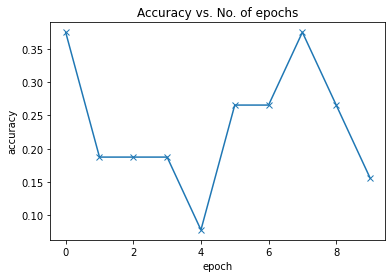

In [34]:
plot_accuracies(history)

In [35]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_dl):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

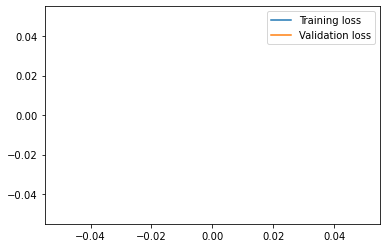

In [ ]:
# # plotting the training and validation loss
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend()
# plt.show()

In [ ]:
# # prediction for training set
# with torch.no_grad():
#     output = model(train_x.cuda())
    
# softmax = torch.exp(output).cpu()
# prob = list(softmax.numpy())
# predictions = np.argmax(prob, axis=1)

# # accuracy on training set
# accuracy_score(train_y, predictions)

In [ ]:
# # prediction for validation set
# with torch.no_grad():
#     output = model(val_x.cuda())

# softmax = torch.exp(output).cpu()
# prob = list(softmax.numpy())
# predictions = np.argmax(prob, axis=1)

# # accuracy on validation set
# accuracy_score(val_y, predictions)

## Approach number 2 -- still in progress

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


NameError: name 'dataloaders' is not defined